# HW_2

1. Добиться хорошего результата от модели, собранной на занятии (5 угаданныx картинок из 8 предложенных). Варианты изменений:
- изменение слоёв и их количества;
- изменение метода оптимизации;
- изменение процесса обучения;
- *преобразование данных transform

2. *Переписать данный туториал на PyTorch: https://www.tensorflow.org/tutorials/quickstart/beginner?hl=ru

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from collections import OrderedDict

C:\Users\odind\anaconda3\envs\learn_tf_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,  
                                             transform=transforms.ToTensor(), 
                                             download=True)


image, label = train_dataset[0]
print(image.size())
print(label)

Files already downloaded and verified
torch.Size([3, 32, 32])
6


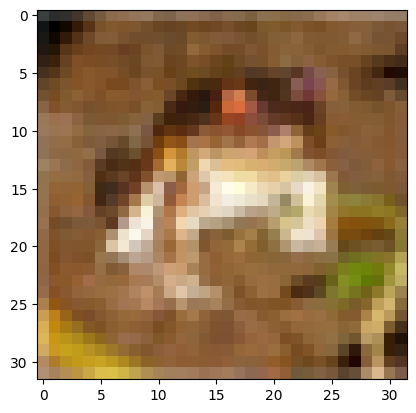

In [4]:
plt.imshow(image.permute(1, 2, 0).numpy())

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

In [6]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64,
                                          shuffle=False)

Files already downloaded and verified


In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, hidden_layers=1, k=2, 
                 activation=F.relu, device_=device):
        super().__init__()
        # input
        self.fc_in = nn.Linear(input_dim, hidden_dim, device=device_)
        # hidden
        for i, _ in enumerate(range(1, hidden_layers)):
            new_hidden_dim = hidden_dim // k
            if new_hidden_dim < output_dim:
                break
            setattr(
                self, 
                f"fc{i}", 
                nn.Linear(hidden_dim, new_hidden_dim, device=device_)
            )
            hidden_dim = new_hidden_dim
        # output
        self.fc_out = nn.Linear(hidden_dim, output_dim, device=device_)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        modules = [_ for _ in self.__dict__['_modules']]
        len_modules = len(modules)
        for i, fc in enumerate(modules, start=1):
            x = eval(f"self.{fc}(x)")
            if i < len_modules:
                x = activation(x)
        return x
    
    def predict(self, x):
        return F.softmax(self.forward(x))

In [9]:
net = Net(
    input_dim=3072, 
    hidden_dim=400, 
    output_dim=10, 
    hidden_layers=3, 
    k=2,     
    activation='relu',  
    device_=device
)

In [10]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0)

In [11]:
n_layers = [3, 
            5, 
            7, 
            10
           ]
hidden_dims = [200, 
               400, 
               800
              ]
activations = [F.leaky_relu, 
               F.elu
              ]
optimizers = [optim.Adam, 
              optim.SGD
             ]

len_set = len(n_layers) * len(hidden_dims) * len(activations) * len(optimizers)
n_set = 1
epochs = 20

In [12]:
nets = []

In [13]:
%%time
    
for hidden_layers in n_layers:
    for hidden_dim in hidden_dims:
        for activation in activations:
            net = Net(
                input_dim=3072, 
                hidden_dim=hidden_dim, 
                output_dim=10, 
                hidden_layers=hidden_layers, 
                k=2,     
                activation=activation, 
                device_=device
            )
            net.train()

            for func in optimizers:
                optimizer = func(net.parameters(), lr=0.005)
                
                name = f'{str(optimizer).split( )[0]}_{hidden_layers}_{hidden_dim}_{str(activation).split( )[1]}'

                net_loss = 0
                for epoch in range(epochs):
                    running_loss = 0.0
                    n = 0

                    for i, data in enumerate(train_loader):
                        inputs, labels = data[0].cuda(), data[1].cuda()
                        n += len(labels)

                         # Обнуляем градиент
                        optimizer.zero_grad()
                        # Делаем предсказание
                        outputs = net(inputs)
                        # Рассчитываем лосс-функцию
                        loss = criterion(outputs, labels)
                        # Делаем шаг назад по лоссу
                        loss.backward()
                        # Делаем шаг нашего оптимайзера
                        optimizer.step()
                        # выводим статистику о процессе обучения
                        running_loss += loss.item()
                    
                    running_loss /= n
                    print(f'{name}\n' \
                          f'Epoch [{epoch + 1}/{epochs}]. ' \
                          f'Loss: {running_loss:.4f}')
                    net_loss = running_loss
                    running_loss = 0.0
                    
                data_iter = iter(test_loader)
                images, labels = data_iter._next_data()
                net.eval()
                outputs = net(images.cuda())
                _, predicted = torch.max(outputs, 1)
                gt = np.array([classes[labels[j]] for j in range(len(labels))])
                pred = np.array([classes[predicted[j]] for j in range(len(labels))])
                accuracy = (gt == pred).sum() / len(gt)
                net.train()
                
                print(f'\n[{n_set}/{len_set}] accuracy {accuracy}\n{"-"*40}\n')
                n_set += 1
                
                nets.append({
                    'name': name,
                    'net': net,
                    'loss': net_loss,
                    'accuracy': accuracy
                })

Adam_3_200_leaky_relu
Epoch [1/20]. Loss: 0.0300
Adam_3_200_leaky_relu
Epoch [2/20]. Loss: 0.0277
Adam_3_200_leaky_relu
Epoch [3/20]. Loss: 0.0267
Adam_3_200_leaky_relu
Epoch [4/20]. Loss: 0.0263
Adam_3_200_leaky_relu
Epoch [5/20]. Loss: 0.0258
Adam_3_200_leaky_relu
Epoch [6/20]. Loss: 0.0256
Adam_3_200_leaky_relu
Epoch [7/20]. Loss: 0.0253
Adam_3_200_leaky_relu
Epoch [8/20]. Loss: 0.0252
Adam_3_200_leaky_relu
Epoch [9/20]. Loss: 0.0254
Adam_3_200_leaky_relu
Epoch [10/20]. Loss: 0.0248
Adam_3_200_leaky_relu
Epoch [11/20]. Loss: 0.0247
Adam_3_200_leaky_relu
Epoch [12/20]. Loss: 0.0246
Adam_3_200_leaky_relu
Epoch [13/20]. Loss: 0.0242
Adam_3_200_leaky_relu
Epoch [14/20]. Loss: 0.0241
Adam_3_200_leaky_relu
Epoch [15/20]. Loss: 0.0255
Adam_3_200_leaky_relu
Epoch [16/20]. Loss: 0.0240
Adam_3_200_leaky_relu
Epoch [17/20]. Loss: 0.0237
Adam_3_200_leaky_relu
Epoch [18/20]. Loss: 0.0234
Adam_3_200_leaky_relu
Epoch [19/20]. Loss: 0.0234
Adam_3_200_leaky_relu
Epoch [20/20]. Loss: 0.0236

[1/48] a

Adam_3_800_leaky_relu
Epoch [9/20]. Loss: 0.0262
Adam_3_800_leaky_relu
Epoch [10/20]. Loss: 0.0890
Adam_3_800_leaky_relu
Epoch [11/20]. Loss: 0.0284
Adam_3_800_leaky_relu
Epoch [12/20]. Loss: 0.0272
Adam_3_800_leaky_relu
Epoch [13/20]. Loss: 0.0264
Adam_3_800_leaky_relu
Epoch [14/20]. Loss: 0.0261
Adam_3_800_leaky_relu
Epoch [15/20]. Loss: 0.0260
Adam_3_800_leaky_relu
Epoch [16/20]. Loss: 0.0255
Adam_3_800_leaky_relu
Epoch [17/20]. Loss: 0.0254
Adam_3_800_leaky_relu
Epoch [18/20]. Loss: 0.0250
Adam_3_800_leaky_relu
Epoch [19/20]. Loss: 0.0257
Adam_3_800_leaky_relu
Epoch [20/20]. Loss: 0.0247

[9/48] accuracy 0.34375
----------------------------------------

SGD_3_800_leaky_relu
Epoch [1/20]. Loss: 0.0241
SGD_3_800_leaky_relu
Epoch [2/20]. Loss: 0.0234
SGD_3_800_leaky_relu
Epoch [3/20]. Loss: 0.0230
SGD_3_800_leaky_relu
Epoch [4/20]. Loss: 0.0229
SGD_3_800_leaky_relu
Epoch [5/20]. Loss: 0.0228
SGD_3_800_leaky_relu
Epoch [6/20]. Loss: 0.0227
SGD_3_800_leaky_relu
Epoch [7/20]. Loss: 0.022

Adam_5_400_leaky_relu
Epoch [17/20]. Loss: 0.0266
Adam_5_400_leaky_relu
Epoch [18/20]. Loss: 0.0257
Adam_5_400_leaky_relu
Epoch [19/20]. Loss: 0.0263
Adam_5_400_leaky_relu
Epoch [20/20]. Loss: 0.0261

[17/48] accuracy 0.453125
----------------------------------------

SGD_5_400_leaky_relu
Epoch [1/20]. Loss: 0.0245
SGD_5_400_leaky_relu
Epoch [2/20]. Loss: 0.0244
SGD_5_400_leaky_relu
Epoch [3/20]. Loss: 0.0243
SGD_5_400_leaky_relu
Epoch [4/20]. Loss: 0.0243
SGD_5_400_leaky_relu
Epoch [5/20]. Loss: 0.0243
SGD_5_400_leaky_relu
Epoch [6/20]. Loss: 0.0243
SGD_5_400_leaky_relu
Epoch [7/20]. Loss: 0.0243
SGD_5_400_leaky_relu
Epoch [8/20]. Loss: 0.0242
SGD_5_400_leaky_relu
Epoch [9/20]. Loss: 0.0242
SGD_5_400_leaky_relu
Epoch [10/20]. Loss: 0.0242
SGD_5_400_leaky_relu
Epoch [11/20]. Loss: 0.0242
SGD_5_400_leaky_relu
Epoch [12/20]. Loss: 0.0242
SGD_5_400_leaky_relu
Epoch [13/20]. Loss: 0.0242
SGD_5_400_leaky_relu
Epoch [14/20]. Loss: 0.0242
SGD_5_400_leaky_relu
Epoch [15/20]. Loss: 0.0241
SGD_5

SGD_7_200_leaky_relu
Epoch [3/20]. Loss: 0.0228
SGD_7_200_leaky_relu
Epoch [4/20]. Loss: 0.0228
SGD_7_200_leaky_relu
Epoch [5/20]. Loss: 0.0227
SGD_7_200_leaky_relu
Epoch [6/20]. Loss: 0.0227
SGD_7_200_leaky_relu
Epoch [7/20]. Loss: 0.0227
SGD_7_200_leaky_relu
Epoch [8/20]. Loss: 0.0227
SGD_7_200_leaky_relu
Epoch [9/20]. Loss: 0.0227
SGD_7_200_leaky_relu
Epoch [10/20]. Loss: 0.0227
SGD_7_200_leaky_relu
Epoch [11/20]. Loss: 0.0226
SGD_7_200_leaky_relu
Epoch [12/20]. Loss: 0.0226
SGD_7_200_leaky_relu
Epoch [13/20]. Loss: 0.0226
SGD_7_200_leaky_relu
Epoch [14/20]. Loss: 0.0226
SGD_7_200_leaky_relu
Epoch [15/20]. Loss: 0.0226
SGD_7_200_leaky_relu
Epoch [16/20]. Loss: 0.0226
SGD_7_200_leaky_relu
Epoch [17/20]. Loss: 0.0226
SGD_7_200_leaky_relu
Epoch [18/20]. Loss: 0.0226
SGD_7_200_leaky_relu
Epoch [19/20]. Loss: 0.0226
SGD_7_200_leaky_relu
Epoch [20/20]. Loss: 0.0226

[26/48] accuracy 0.53125
----------------------------------------

Adam_7_200_elu
Epoch [1/20]. Loss: 0.0310
Adam_7_200_elu


SGD_7_800_leaky_relu
Epoch [12/20]. Loss: nan
SGD_7_800_leaky_relu
Epoch [13/20]. Loss: nan
SGD_7_800_leaky_relu
Epoch [14/20]. Loss: nan
SGD_7_800_leaky_relu
Epoch [15/20]. Loss: nan
SGD_7_800_leaky_relu
Epoch [16/20]. Loss: nan
SGD_7_800_leaky_relu
Epoch [17/20]. Loss: nan
SGD_7_800_leaky_relu
Epoch [18/20]. Loss: nan
SGD_7_800_leaky_relu
Epoch [19/20]. Loss: nan
SGD_7_800_leaky_relu
Epoch [20/20]. Loss: nan

[34/48] accuracy 0.09375
----------------------------------------

Adam_7_800_elu
Epoch [1/20]. Loss: 0.0326
Adam_7_800_elu
Epoch [2/20]. Loss: 0.0310
Adam_7_800_elu
Epoch [3/20]. Loss: 0.0296
Adam_7_800_elu
Epoch [4/20]. Loss: 0.0289
Adam_7_800_elu
Epoch [5/20]. Loss: 0.0284
Adam_7_800_elu
Epoch [6/20]. Loss: 0.0278
Adam_7_800_elu
Epoch [7/20]. Loss: 0.0275
Adam_7_800_elu
Epoch [8/20]. Loss: 0.0272
Adam_7_800_elu
Epoch [9/20]. Loss: 0.0268
Adam_7_800_elu
Epoch [10/20]. Loss: 0.0282
Adam_7_800_elu
Epoch [11/20]. Loss: 0.0269
Adam_7_800_elu
Epoch [12/20]. Loss: 0.0264
Adam_7_800_

SGD_10_400_leaky_relu
Epoch [18/20]. Loss: 0.0249
SGD_10_400_leaky_relu
Epoch [19/20]. Loss: 0.0249
SGD_10_400_leaky_relu
Epoch [20/20]. Loss: 0.0249

[42/48] accuracy 0.390625
----------------------------------------

Adam_10_400_elu
Epoch [1/20]. Loss: 0.0314
Adam_10_400_elu
Epoch [2/20]. Loss: 0.0290
Adam_10_400_elu
Epoch [3/20]. Loss: 0.0282
Adam_10_400_elu
Epoch [4/20]. Loss: 0.0274
Adam_10_400_elu
Epoch [5/20]. Loss: 0.0266
Adam_10_400_elu
Epoch [6/20]. Loss: 0.0260
Adam_10_400_elu
Epoch [7/20]. Loss: 0.0257
Adam_10_400_elu
Epoch [8/20]. Loss: 0.0254
Adam_10_400_elu
Epoch [9/20]. Loss: 0.0249
Adam_10_400_elu
Epoch [10/20]. Loss: 0.0246
Adam_10_400_elu
Epoch [11/20]. Loss: 0.0245
Adam_10_400_elu
Epoch [12/20]. Loss: 0.0243
Adam_10_400_elu
Epoch [13/20]. Loss: 0.0240
Adam_10_400_elu
Epoch [14/20]. Loss: 0.0238
Adam_10_400_elu
Epoch [15/20]. Loss: 0.0237
Adam_10_400_elu
Epoch [16/20]. Loss: 0.0235
Adam_10_400_elu
Epoch [17/20]. Loss: 0.0239
Adam_10_400_elu
Epoch [18/20]. Loss: 0.023

In [14]:
pd.DataFrame(nets).sort_values(by=['accuracy'], ascending=False)[:20]

,name,net,loss,accuracy
5,SGD_3_400_leaky_relu,"Net(\n (fc_in): Linear(in_features=3072, out_...",0.021381,0.531250
25,SGD_7_200_leaky_relu,"Net(\n (fc_in): Linear(in_features=3072, out_...",0.022577,0.531250
4,Adam_3_400_leaky_relu,"Net(\n (fc_in): Linear(in_features=3072, out_...",0.023249,0.515625
37,SGD_10_200_leaky_relu,"Net(\n (fc_in): Linear(in_features=3072, out_...",0.022326,0.515625
0,Adam_3_200_leaky_relu,"Net(\n (fc_in): Linear(in_features=3072, out_...",0.023613,0.500000
17,SGD_5_400_leaky_relu,"Net(\n (fc_in): Linear(in_features=3072, out_...",0.024086,0.500000
39,SGD_10_200_elu,"Net(\n (fc_in): Linear(in_features=3072, out_...",0.021337,0.500000
7,SGD_3_400_elu,"Net(\n (fc_in): Linear(in_features=3072, out_...",0.021840,0.500000
28,Adam_7_400_leaky_relu,"Net(\n (fc_in): Linear(in_features=3072, out_...",0.024985,0.500000
27,SGD_7_200_elu,"Net(\n (fc_in): Linear(in_features=3072, out_...",0.022327,0.500000


In [15]:
net = pd.DataFrame(nets).sort_values(by=['loss'], ignore_index=True)[:20].loc[0]['net']

In [16]:
data_iter = iter(test_loader)
images, labels = data_iter._next_data()

GroundTruth:  cat ship ship plane frog frog car frog cat car plane truck dog horse truck ship dog horse ship frog horse plane deer truck dog bird deer plane truck frog frog dog deer dog truck bird deer car truck dog deer frog dog frog plane truck cat truck horse frog truck ship plane cat ship ship horse horse deer frog horse cat frog cat


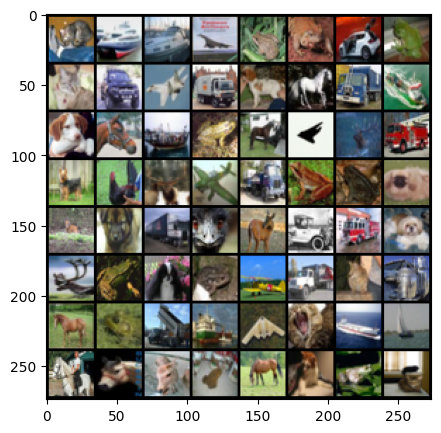

In [17]:
net.eval()
outputs = net(images.cuda())
imgs = torchvision.utils.make_grid(images)
plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('GroundTruth: ', ' '.join(classes[labels[j]] for j in range(len(labels))))

In [18]:
print(outputs)

tensor([[-9.2258e-01, -1.6556e+00, -1.1929e+00,  6.6547e-01, -1.9281e+00,
          2.0479e-02, -1.2769e+00, -1.5496e+00, -1.2984e+00, -2.1404e+00],
        [ 1.5693e+00,  2.3056e+00, -1.6280e+00, -1.6897e+00, -1.2764e+00,
         -2.4240e+00, -2.7952e+00, -1.9080e+00,  2.4444e+00,  2.5485e+00],
        [ 2.6516e+00,  2.1411e-01, -2.6181e-01, -2.0291e+00, -2.3897e-01,
         -2.9847e+00, -2.8109e+00, -1.8679e+00,  1.1018e+00, -2.3726e-01],
        [ 2.9873e+00,  4.8178e-01,  1.1292e-01, -1.9239e+00, -1.4006e-01,
         -2.7559e+00, -2.4925e+00, -2.1007e+00,  1.1429e+00, -1.0420e+00],
        [ 3.4435e-01, -2.7284e+00,  2.9074e+00, -2.9985e-01,  4.0459e+00,
         -1.5893e+00,  3.6034e+00, -1.4744e+00, -2.6442e+00, -2.3673e+00],
        [-1.5667e+00, -1.8945e+00, -2.8338e-01,  3.7128e-01, -9.1882e-01,
         -3.9483e-01,  4.1022e-02, -1.3215e+00, -3.2878e+00, -1.9417e+00],
        [-1.5321e+00, -2.7673e-01, -1.2910e+00, -2.1712e-01, -2.7320e+00,
         -6.6437e-01, -1.8085e+0

In [19]:
net.predict(images.cuda())

C:\Users\odind\AppData\Local\Temp\ipykernel_1728\1740803598.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.forward(x))


tensor([[8.1368e-02, 3.9092e-02, 6.2094e-02, 3.9823e-01, 2.9769e-02, 2.0894e-01,
         5.7092e-02, 4.3465e-02, 5.5877e-02, 2.4075e-02],
        [1.1978e-01, 2.5011e-01, 4.8952e-03, 4.6024e-03, 6.9580e-03, 2.2084e-03,
         1.5236e-03, 3.6998e-03, 2.8734e-01, 3.1888e-01],
        [6.6973e-01, 5.8521e-02, 3.6360e-02, 6.2100e-03, 3.7200e-02, 2.3882e-03,
         2.8417e-03, 7.2964e-03, 1.4218e-01, 3.7264e-02],
        [7.2530e-01, 5.9209e-02, 4.0944e-02, 5.3411e-03, 3.1793e-02, 2.3243e-03,
         3.0245e-03, 4.4753e-03, 1.1469e-01, 1.2901e-02],
        [1.2269e-02, 5.6798e-04, 1.5920e-01, 6.4425e-03, 4.9702e-01, 1.7744e-03,
         3.1930e-01, 1.9905e-03, 6.1791e-04, 8.1499e-04],
        [4.0735e-02, 2.9350e-02, 1.4700e-01, 2.8289e-01, 7.7865e-02, 1.3149e-01,
         2.0333e-01, 5.2054e-02, 7.2862e-03, 2.7998e-02],
        [6.2349e-02, 2.1879e-01, 7.9350e-02, 2.3223e-01, 1.8781e-02, 1.4848e-01,
         4.7294e-02, 6.5643e-02, 2.0278e-02, 1.0681e-01],
        [2.2660e-03, 1.1015

In [20]:
_, predicted = torch.max(outputs, 1)

predicted

tensor([3, 9, 0, 0, 4, 3, 3, 6, 5, 1, 0, 9, 6, 0, 1, 8, 5, 4, 8, 6, 5, 2, 0, 1,
        4, 6, 6, 2, 9, 6, 6, 2, 4, 6, 9, 3, 6, 1, 9, 8, 0, 6, 3, 6, 0, 0, 3, 9,
        4, 6, 9, 0, 6, 3, 8, 8, 5, 6, 3, 4, 4, 3, 4, 3], device='cuda:0')

In [21]:
print('Predicted: ', ' '.join(classes[predicted[j]] for j in range(len(labels))))

Predicted:  cat truck plane plane deer cat cat frog dog car plane truck frog plane car ship dog deer ship frog dog bird plane car deer frog frog bird truck frog frog bird deer frog truck cat frog car truck ship plane frog cat frog plane plane cat truck deer frog truck plane frog cat ship ship dog frog cat deer deer cat deer cat


In [22]:
gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt[:8])
print(pred[:8])
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'truck' 'plane' 'plane' 'deer' 'cat' 'cat' 'frog']
Accuracy is 0.453125


In [23]:
5/8

0.625

In [24]:
PATH_MODEL = './cifar_net_test_version_model.pth'
torch.save(net, PATH_MODEL)

In [25]:
net = torch.load(PATH_MODEL)

3 из 8 - маловато. Нужно продолжать искать

Попытка 2. Сузил круг поиска на основе предыдущей таблицы

In [26]:
n_layers = [2, 
            3
           ]
hidden_dims = [100, 
               200, 
               300,
               400
              ]
activations = [F.leaky_relu
              ]
optimizers = [optim.Adam, 
              optim.SGD
             ]

len_set = len(n_layers) * len(hidden_dims) * len(activations) * len(optimizers)
n_set = 1
epochs = 50

In [40]:
%%time
    
for hidden_layers in n_layers:
    for hidden_dim in hidden_dims:
        for activation in activations:
            net = Net(
                input_dim=3072, 
                hidden_dim=hidden_dim, 
                output_dim=10, 
                hidden_layers=hidden_layers, 
                k=2,     
                activation=activation, 
                device_=device
            )
            net.train()

            for func in optimizers:
                optimizer = func(net.parameters(), lr=0.001)
                
                name = f'2_{str(optimizer).split( )[0]}_{hidden_layers}_{hidden_dim}_{str(activation).split( )[1]}'

                net_loss = 0
                learning_rate_k = 0  # рука-лицо. я имел ввиду early stopping
                min_loss = 100000
                for epoch in range(epochs):
                    running_loss = 0.0
                    n = 0

                    for i, data in enumerate(train_loader):
                        inputs, labels = data[0].cuda(), data[1].cuda()
                        n += len(labels)

                         # Обнуляем градиент
                        optimizer.zero_grad()
                        # Делаем предсказание
                        outputs = net(inputs)
                        # Рассчитываем лосс-функцию
                        loss = criterion(outputs, labels)
                        # Делаем шаг назад по лоссу
                        loss.backward()
                        # Делаем шаг нашего оптимайзера
                        optimizer.step()
                        # выводим статистику о процессе обучения
                        running_loss += loss.item()
                    
                    running_loss /= n
                    print(f'{name}\n' \
                          f'Epoch [{epoch + 1}/{epochs}]. ' \
                          f'Loss: {running_loss:.4f}')
                    net_loss = running_loss
                    
                    if min_loss - net_loss > 1e-4:
                        min_loss = net_loss
                        learning_rate_k = 0
                    else:
                        learning_rate_k += 1
                    if learning_rate_k > 5:
                        print('learning_rate stop')  # рука-лицо. я имел ввиду early stopping
                        break
                    
                data_iter = iter(test_loader)
                images, labels = data_iter._next_data()
                net.eval()
                outputs = net(images.cuda())
                _, predicted = torch.max(outputs, 1)
                gt = np.array([classes[labels[j]] for j in range(len(labels))])
                pred = np.array([classes[predicted[j]] for j in range(len(labels))])
                accuracy = (gt == pred).sum() / len(gt)
                net.train()
                
                print(f'\n[{n_set}/{len_set}] accuracy {accuracy}\n{"-"*40}\n')
                n_set += 1
                
                nets.append({
                    'name': name,
                    'net': net,
                    'loss': net_loss,
                    'accuracy': accuracy
                })

2_Adam_2_100_leaky_relu
Epoch [1/50]. Loss: 0.0292
2_Adam_2_100_leaky_relu
Epoch [2/50]. Loss: 0.0265
2_Adam_2_100_leaky_relu
Epoch [3/50]. Loss: 0.0254
2_Adam_2_100_leaky_relu
Epoch [4/50]. Loss: 0.0246
2_Adam_2_100_leaky_relu
Epoch [5/50]. Loss: 0.0239
2_Adam_2_100_leaky_relu
Epoch [6/50]. Loss: 0.0234
2_Adam_2_100_leaky_relu
Epoch [7/50]. Loss: 0.0230
2_Adam_2_100_leaky_relu
Epoch [8/50]. Loss: 0.0226
2_Adam_2_100_leaky_relu
Epoch [9/50]. Loss: 0.0224
2_Adam_2_100_leaky_relu
Epoch [10/50]. Loss: 0.0222
2_Adam_2_100_leaky_relu
Epoch [11/50]. Loss: 0.0219
2_Adam_2_100_leaky_relu
Epoch [12/50]. Loss: 0.0216
2_Adam_2_100_leaky_relu
Epoch [13/50]. Loss: 0.0215
2_Adam_2_100_leaky_relu
Epoch [14/50]. Loss: 0.0212
2_Adam_2_100_leaky_relu
Epoch [15/50]. Loss: 0.0210
2_Adam_2_100_leaky_relu
Epoch [16/50]. Loss: 0.0208
2_Adam_2_100_leaky_relu
Epoch [17/50]. Loss: 0.0207
2_Adam_2_100_leaky_relu
Epoch [18/50]. Loss: 0.0205
2_Adam_2_100_leaky_relu
Epoch [19/50]. Loss: 0.0203
2_Adam_2_100_leaky_re

2_Adam_2_300_leaky_relu
Epoch [16/50]. Loss: 0.0193
2_Adam_2_300_leaky_relu
Epoch [17/50]. Loss: 0.0191
2_Adam_2_300_leaky_relu
Epoch [18/50]. Loss: 0.0188
2_Adam_2_300_leaky_relu
Epoch [19/50]. Loss: 0.0186
2_Adam_2_300_leaky_relu
Epoch [20/50]. Loss: 0.0183
2_Adam_2_300_leaky_relu
Epoch [21/50]. Loss: 0.0181
2_Adam_2_300_leaky_relu
Epoch [22/50]. Loss: 0.0179
2_Adam_2_300_leaky_relu
Epoch [23/50]. Loss: 0.0177
2_Adam_2_300_leaky_relu
Epoch [24/50]. Loss: 0.0175
2_Adam_2_300_leaky_relu
Epoch [25/50]. Loss: 0.0173
2_Adam_2_300_leaky_relu
Epoch [26/50]. Loss: 0.0171
2_Adam_2_300_leaky_relu
Epoch [27/50]. Loss: 0.0170
2_Adam_2_300_leaky_relu
Epoch [28/50]. Loss: 0.0166
2_Adam_2_300_leaky_relu
Epoch [29/50]. Loss: 0.0165
2_Adam_2_300_leaky_relu
Epoch [30/50]. Loss: 0.0163
2_Adam_2_300_leaky_relu
Epoch [31/50]. Loss: 0.0161
2_Adam_2_300_leaky_relu
Epoch [32/50]. Loss: 0.0160
2_Adam_2_300_leaky_relu
Epoch [33/50]. Loss: 0.0158
2_Adam_2_300_leaky_relu
Epoch [34/50]. Loss: 0.0156
2_Adam_2_300

2_Adam_3_100_leaky_relu
Epoch [18/50]. Loss: 0.0204
2_Adam_3_100_leaky_relu
Epoch [19/50]. Loss: 0.0203
2_Adam_3_100_leaky_relu
Epoch [20/50]. Loss: 0.0201
2_Adam_3_100_leaky_relu
Epoch [21/50]. Loss: 0.0200
2_Adam_3_100_leaky_relu
Epoch [22/50]. Loss: 0.0198
2_Adam_3_100_leaky_relu
Epoch [23/50]. Loss: 0.0196
2_Adam_3_100_leaky_relu
Epoch [24/50]. Loss: 0.0195
2_Adam_3_100_leaky_relu
Epoch [25/50]. Loss: 0.0194
2_Adam_3_100_leaky_relu
Epoch [26/50]. Loss: 0.0193
2_Adam_3_100_leaky_relu
Epoch [27/50]. Loss: 0.0191
2_Adam_3_100_leaky_relu
Epoch [28/50]. Loss: 0.0190
2_Adam_3_100_leaky_relu
Epoch [29/50]. Loss: 0.0189
2_Adam_3_100_leaky_relu
Epoch [30/50]. Loss: 0.0187
2_Adam_3_100_leaky_relu
Epoch [31/50]. Loss: 0.0186
2_Adam_3_100_leaky_relu
Epoch [32/50]. Loss: 0.0185
2_Adam_3_100_leaky_relu
Epoch [33/50]. Loss: 0.0184
2_Adam_3_100_leaky_relu
Epoch [34/50]. Loss: 0.0183
2_Adam_3_100_leaky_relu
Epoch [35/50]. Loss: 0.0181
2_Adam_3_100_leaky_relu
Epoch [36/50]. Loss: 0.0181
2_Adam_3_100

2_Adam_3_300_leaky_relu
Epoch [33/50]. Loss: 0.0148
2_Adam_3_300_leaky_relu
Epoch [34/50]. Loss: 0.0146
2_Adam_3_300_leaky_relu
Epoch [35/50]. Loss: 0.0145
2_Adam_3_300_leaky_relu
Epoch [36/50]. Loss: 0.0143
2_Adam_3_300_leaky_relu
Epoch [37/50]. Loss: 0.0140
2_Adam_3_300_leaky_relu
Epoch [38/50]. Loss: 0.0138
2_Adam_3_300_leaky_relu
Epoch [39/50]. Loss: 0.0137
2_Adam_3_300_leaky_relu
Epoch [40/50]. Loss: 0.0137
2_Adam_3_300_leaky_relu
Epoch [41/50]. Loss: 0.0133
2_Adam_3_300_leaky_relu
Epoch [42/50]. Loss: 0.0134
2_Adam_3_300_leaky_relu
Epoch [43/50]. Loss: 0.0131
2_Adam_3_300_leaky_relu
Epoch [44/50]. Loss: 0.0129
2_Adam_3_300_leaky_relu
Epoch [45/50]. Loss: 0.0128
2_Adam_3_300_leaky_relu
Epoch [46/50]. Loss: 0.0128
2_Adam_3_300_leaky_relu
Epoch [47/50]. Loss: 0.0126
2_Adam_3_300_leaky_relu
Epoch [48/50]. Loss: 0.0123
2_Adam_3_300_leaky_relu
Epoch [49/50]. Loss: 0.0122
2_Adam_3_300_leaky_relu
Epoch [50/50]. Loss: 0.0120

[13/16] accuracy 0.5625
---------------------------------------

In [41]:
pd.DataFrame(nets).sort_values(by=['accuracy'], ascending=False)[:20]

,name,net,loss,accuracy
61,2_SGD_3_300_leaky_relu,"Net(\n (fc_in): Linear(in_features=3072, out_...",0.008243,0.609375
55,2_SGD_2_400_leaky_relu,"Net(\n (fc_in): Linear(in_features=3072, out_...",0.008791,0.578125
53,2_SGD_2_300_leaky_relu,"Net(\n (fc_in): Linear(in_features=3072, out_...",0.010035,0.578125
60,2_Adam_3_300_leaky_relu,"Net(\n (fc_in): Linear(in_features=3072, out_...",0.012043,0.562500
51,2_SGD_2_200_leaky_relu,"Net(\n (fc_in): Linear(in_features=3072, out_...",0.011530,0.546875
62,2_Adam_3_400_leaky_relu,"Net(\n (fc_in): Linear(in_features=3072, out_...",0.011262,0.546875
48,2_Adam_2_100_leaky_relu,"Net(\n (fc_in): Linear(in_features=3072, out_...",0.016975,0.546875
49,2_SGD_2_100_leaky_relu,"Net(\n (fc_in): Linear(in_features=3072, out_...",0.014944,0.546875
5,SGD_3_400_leaky_relu,"Net(\n (fc_in): Linear(in_features=3072, out_...",0.021381,0.531250
25,SGD_7_200_leaky_relu,"Net(\n (fc_in): Linear(in_features=3072, out_...",0.022577,0.531250


In [42]:
net = pd.DataFrame(nets).sort_values(by=['loss'], ignore_index=True)[:20].loc[0]['net']

In [43]:
data_iter = iter(test_loader)
images, labels = data_iter._next_data()

GroundTruth:  cat ship ship plane frog frog car frog cat car plane truck dog horse truck ship dog horse ship frog horse plane deer truck dog bird deer plane truck frog frog dog deer dog truck bird deer car truck dog deer frog dog frog plane truck cat truck horse frog truck ship plane cat ship ship horse horse deer frog horse cat frog cat


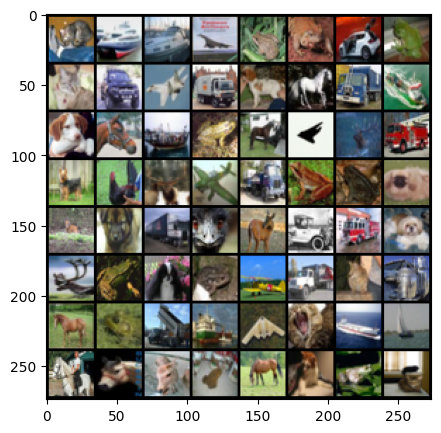

In [44]:
net.eval()
outputs = net(images.cuda())
imgs = torchvision.utils.make_grid(images)
plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('GroundTruth: ', ' '.join(classes[labels[j]] for j in range(len(labels))))

In [45]:
print(outputs)

tensor([[-4.0290e+00, -3.6371e+00,  2.0204e+00,  3.4625e+00,  3.0521e+00,
         -1.9731e+00,  1.1550e+00, -6.8939e+00, -6.1772e+00, -3.6004e+00],
        [-2.7567e+00,  2.8433e+00, -3.3778e+00, -8.7312e+00, -7.7107e+00,
         -5.8904e+00, -3.9119e+00, -9.0311e+00,  6.5222e+00,  1.9970e+00],
        [ 4.2352e+00,  5.7309e+00, -2.7350e+00, -6.9853e+00, -5.0683e+00,
         -8.4525e+00, -8.0135e+00,  8.7668e-01,  5.6748e+00,  1.7554e+00],
        [ 4.0906e+00, -1.5193e+00,  1.9447e+00, -7.1638e+00, -1.6629e+00,
         -4.0881e+00, -7.8026e+00,  9.6890e-01,  1.4044e+00, -1.7463e+00],
        [-9.4368e+00, -1.4373e+01,  3.0787e+00,  2.3111e+00,  6.3072e+00,
          1.9044e+00,  4.9587e+00, -4.4677e+00, -8.1576e+00, -1.4210e+01],
        [-4.9015e+00, -8.6980e+00, -3.3242e+00,  3.0567e+00,  1.3214e+00,
         -1.6436e+00,  7.1585e+00, -7.1018e+00, -1.1085e+01, -3.4725e+00],
        [-4.4309e+00,  1.1334e+01, -1.5602e+00,  3.6094e+00, -2.6700e+01,
         -1.1759e+00, -1.5644e+0

In [46]:
net.predict(images.cuda())

C:\Users\odind\AppData\Local\Temp\ipykernel_1728\1740803598.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.forward(x))


tensor([[2.7806e-04, 4.1149e-04, 1.1786e-01, 4.9850e-01, 3.3070e-01, 2.1727e-03,
         4.9604e-02, 1.5846e-05, 3.2448e-05, 4.2684e-04],
        [9.0111e-05, 2.4367e-02, 4.8419e-05, 2.2912e-07, 6.3572e-07, 3.9247e-06,
         2.8385e-05, 1.6976e-07, 9.6501e-01, 1.0454e-02],
        [1.0203e-01, 4.5530e-01, 9.5849e-05, 1.3668e-06, 9.2950e-06, 3.1516e-07,
         4.8883e-07, 3.5492e-03, 4.3047e-01, 8.5459e-03],
        [8.0695e-01, 2.9544e-03, 9.4381e-02, 1.0450e-05, 2.5592e-03, 2.2639e-04,
         5.5169e-06, 3.5571e-02, 5.4986e-02, 2.3545e-03],
        [1.0931e-07, 7.8506e-10, 2.9790e-02, 1.3827e-02, 7.5193e-01, 9.2060e-03,
         1.9523e-01, 1.5730e-05, 3.9282e-07, 9.2374e-10],
        [5.6750e-06, 1.2740e-07, 2.7475e-05, 1.6223e-02, 2.8610e-03, 1.4752e-04,
         9.8071e-01, 6.2859e-07, 1.1713e-08, 2.3689e-05],
        [1.4228e-07, 9.9945e-01, 2.5113e-06, 4.4157e-04, 3.0319e-17, 3.6881e-06,
         1.9211e-12, 1.2179e-07, 4.8658e-08, 9.9037e-05],
        [1.1709e-07, 1.3004

In [47]:
_, predicted = torch.max(outputs, 1)

predicted

tensor([3, 8, 1, 0, 4, 6, 1, 6, 2, 9, 0, 9, 5, 7, 9, 8, 7, 4, 8, 6, 4, 2, 2, 9,
        4, 2, 3, 4, 9, 6, 6, 4, 4, 5, 9, 1, 3, 9, 9, 6, 4, 6, 3, 2, 4, 1, 5, 3,
        7, 4, 9, 6, 5, 3, 8, 8, 5, 8, 3, 2, 7, 3, 6, 9], device='cuda:0')

In [48]:
print('Predicted: ', ' '.join(classes[predicted[j]] for j in range(len(labels))))

Predicted:  cat ship car plane deer frog car frog bird truck plane truck dog horse truck ship horse deer ship frog deer bird bird truck deer bird cat deer truck frog frog deer deer dog truck car cat truck truck frog deer frog cat bird deer car dog cat horse deer truck frog dog cat ship ship dog ship cat bird horse cat frog truck


In [49]:
gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt[:8])
print(pred[:8])
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'ship' 'car' 'plane' 'deer' 'frog' 'car' 'frog']
Accuracy is 0.515625


сеть угадала 6 из 8 представленных примеров, но по метрике, конечно, не очень..

Должно быть так:

In [50]:
5/8

0.625

In [51]:
PATH_MODEL = './cifar_net_test_version_model.pth'
torch.save(net, PATH_MODEL)

In [52]:
net = torch.load(PATH_MODEL)